## Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
PATH = r'P:\PythonScripts'
if PATH not in sys.path:
    sys.path.append(r'P:\PythonScripts')

In [3]:
#Libraries for data
import bloompy as bp

In [4]:
#Libraries for data manipulation and visualisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import EcoProject.EcoData as ed
import technical.indicators as ta
import simulator.simulator as sim

## Technical visualisation

In [7]:
eur = bp.getHistoricalData("EURUSD Index","PX LAST", "20140101", periodicity="DAILY")
cembi = bp.getHistoricalData("JBCDCOMP Index", "PX_LAST", "20011231", periodicity="DAILY")

C:\Users\herve.biancotto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  """Entry point for launching an IPython kernel.
C:\Users\herve.biancotto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  

In [8]:
# Add MA
roll_d = 100
cembi_MA = cembi.rolling(roll_d).mean()
cembi_MA.columns = ['MA']

In [9]:
eur_rsi = ta.rsi(eur, 14)
cembi_rsi = ta.rsi(cembi, 14)

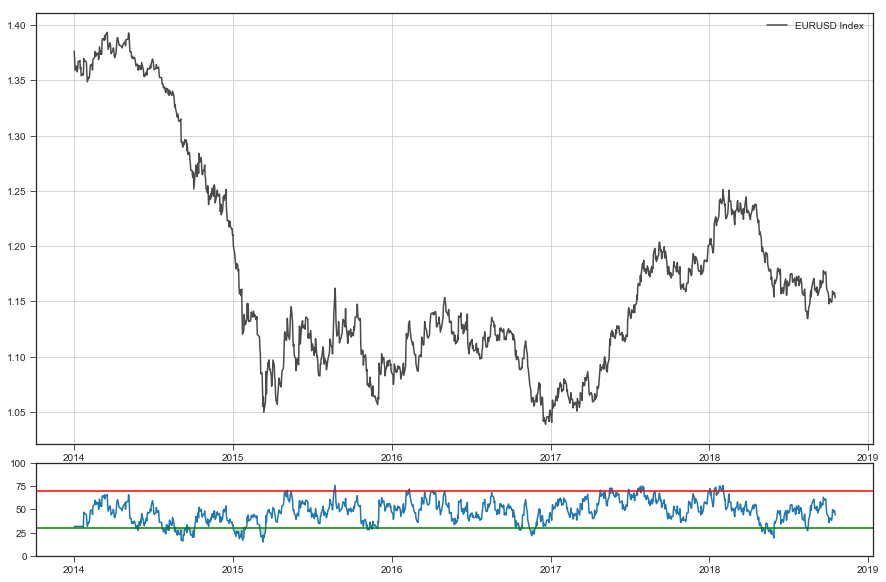

In [10]:
ed.graph(eur, chart_size=(15,10), subgraph=eur_rsi)

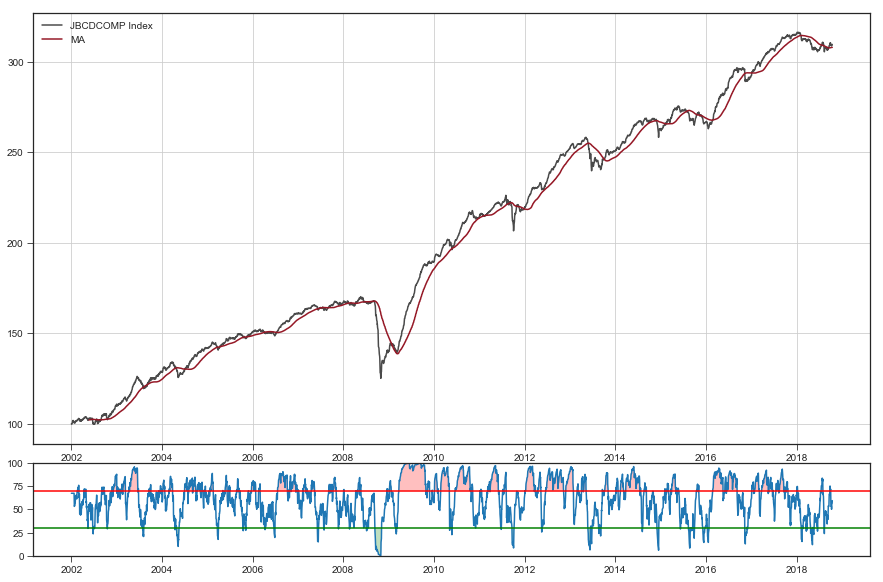

In [11]:
ed.graph(cembi, cembi_MA, chart_size=(15,10), subgraph=cembi_rsi)

In [12]:
sp = bp.getHistoricalData("SPX index", "PX_LAST", "20180101", periodicity="DAILY")
sp_rsi = ta.rsi(sp, 14)

C:\Users\herve.biancotto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  """Entry point for launching an IPython kernel.


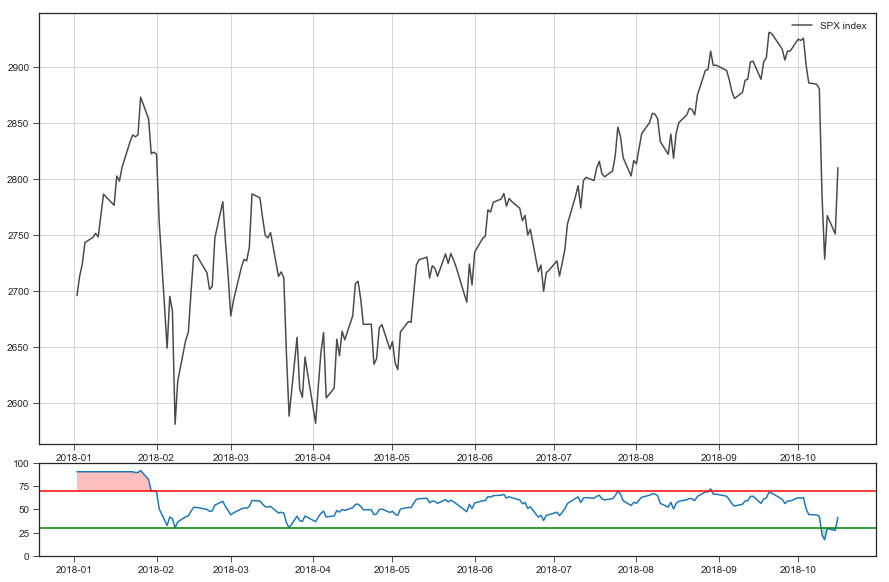

In [13]:
ed.graph(sp, chart_size=(15,10), subgraph=sp_rsi)

## Signal model

In [14]:
spsig = sim.Signal(sp)

In [15]:
spsig.add_rule({'close and sell': [[sp,'cross','below', 2850, None],
                                   [sp_rsi, 'level', 'below', 50,'OR']],
                'cover and buy': [[sp,'level','above', 2800, None],
                                  [sp_rsi,'level','above', 70, 'AND'],
                                  [sp_rsi,'cross','above', 35, 'OR']],
                'exit long': [[sp,'cross','above', 2830, None]],
             })

In [16]:
spsig.eval_strat()

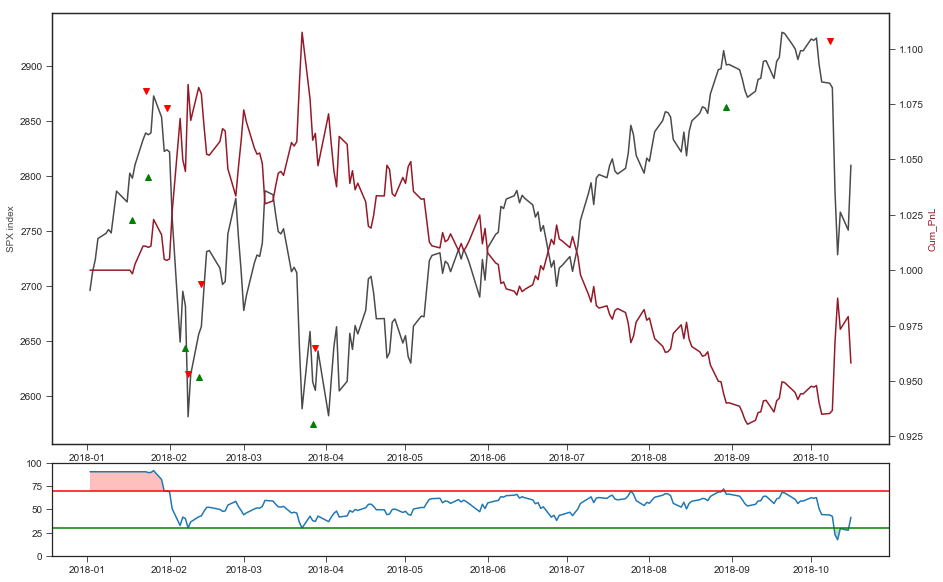

In [17]:
ed.graph(sp, spsig.pnl, multiple_series=True, chart_size=(15,10), legend=False, \
         subgraph=sp_rsi, \
         trading_signal=spsig.trigger, \
         view_grid=True,
         save_fig="t.png")

## Test out cembi strategy

#### At index level

In [18]:
cembi = bp.getHistoricalData("JBCDCOMP Index", "PX_LAST", "20141001", periodicity="DAILY")
rsi_vs = ta.rsi(cembi, 5)
rsi_vs.columns = ['rsi_vs']
rsi_s = ta.rsi(cembi, 8)
rsi_s.columns = ['rsi_s']
rsi_l = ta.rsi(cembi, 18)
rsi_l.columns = ['rsi_l']
ma_vs = cembi.rolling(4).mean()
ma_vs.columns = ['ma_vs']
ma_s = cembi.rolling(10).mean()
ma_s.columns = ['ma_s']
ma_l = cembi.rolling(22).mean()
ma_l.columns = ['ma_l']

C:\Users\herve.biancotto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  """Entry point for launching an IPython kernel.


In [19]:
start_d = pd.to_datetime("2014-11-05")

# Avoid NaN is MA
cembi = cembi[start_d:]
rsi_vs = rsi_vs[start_d:]
rsi_s = rsi_s[start_d:]
rsi_l = rsi_l[start_d:]
ma_vs = ma_vs[start_d:]
ma_s = ma_s[start_d:]
ma_l = ma_l[start_d:]

In [20]:
cemsig = sim.Signal(cembi)
cemsig.add_rule({'cover and buy': [
                                       [rsi_vs,'level','above', rsi_s, None],
                                       [rsi_s,'cross','above', rsi_l, 'AND'],
                                       [rsi_vs,'level','above', 30, 'AND'],
                                       [rsi_s,'level','above', 30, 'AND'],
                                       [rsi_l,'level','above', 30, 'AND'],
                                       [cembi,'level','above', ma_vs, 'AND'],
                                  ],
                  'close and sell': [
                                        [rsi_vs,'level','below', rsi_s, None],
                                        [rsi_s, 'cross', 'below', rsi_l,'AND'],
                                        [rsi_vs,'level','below', 70, 'AND'],
                                        [rsi_s,'level','below', 70, 'AND'],
                                        [rsi_l,'level','below', 70, 'AND'],
                                        [cembi,'level','below', ma_vs, 'AND'],
                                        [rsi_vs,'level','below', 30, 'OR'],
                                        [rsi_s,'level','below', 30, 'AND'],
                                        [rsi_l,'cross','below', 30, 'AND'],
                                    ],
                   'buy': [
                                   [cembi,'level','below', ma_vs, None],
                                   [ma_s, 'level', 'above', ma_l,'AND']
                           ],
                   'exit short': [
                                        [cembi,'cross','above', ma_vs, None],
                                        [ma_s, 'level', 'above', ma_vs,'AND'],
                                        [ma_l, 'level', 'above', ma_s,'AND'],
                                        [rsi_vs, 'level', 'below', 40,'AND'],
                                        [rsi_s, 'level', 'below', 40,'AND'],
                                        [rsi_l, 'level', 'below', 40,'AND']
                                 ]
                })

In [21]:
cemsig.eval_strat()

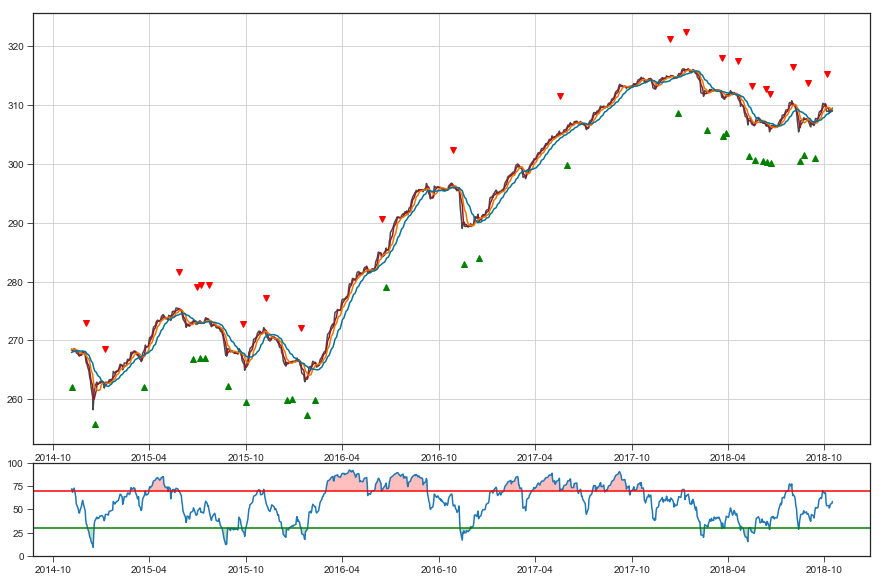

In [22]:
ed.graph(cembi, ma_vs, ma_s, ma_l, chart_size=(15,10), legend=False, \
         subgraph=rsi_l, \
         trading_signal=cemsig.trigger, \
         view_grid=True,
         #save_fig="t.png",
        )

In [23]:
cemsig

* buy : 

    0 - JBCDCOMP Index level below ma_vs

    1 - AND ma_s level above ma_l

* cover and buy : 

    0 - rsi_vs level above rsi_s

    1 - AND rsi_s cross above rsi_l

    2 - AND rsi_vs level above 30

    3 - AND rsi_s level above 30

    4 - AND rsi_l level above 30

    5 - AND JBCDCOMP Index level above ma_vs

* close and sell : 

    0 - rsi_vs level below rsi_s

    1 - AND rsi_s cross below rsi_l

    2 - AND rsi_vs level below 70

    3 - AND rsi_s level below 70

    4 - AND rsi_l level below 70

    5 - AND JBCDCOMP Index level below ma_vs

    6 - OR rsi_vs level below 30

    7 - AND rsi_s level below 30

    8 - AND rsi_l cross below 30

* exit short : 

    0 - JBCDCOMP Index cross above ma_vs

    1 - AND ma_s level above ma_vs

    2 - AND ma_l level above ma_s

    3 - AND rsi_vs level below 40

    4 - AND rsi_s level below 40

    5 - AND rsi_l level below 40



In [24]:
hendo = bp.getHistoricalData("HECA2AU LX Equity", "PX_LAST", "20141105", periodicity="DAILY")
hendo = pd.Series(hendo.iloc[:,0], index=hendo.index) 
hendo = hendo / hendo.iloc[0]

C:\Users\herve.biancotto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  """Entry point for launching an IPython kernel.


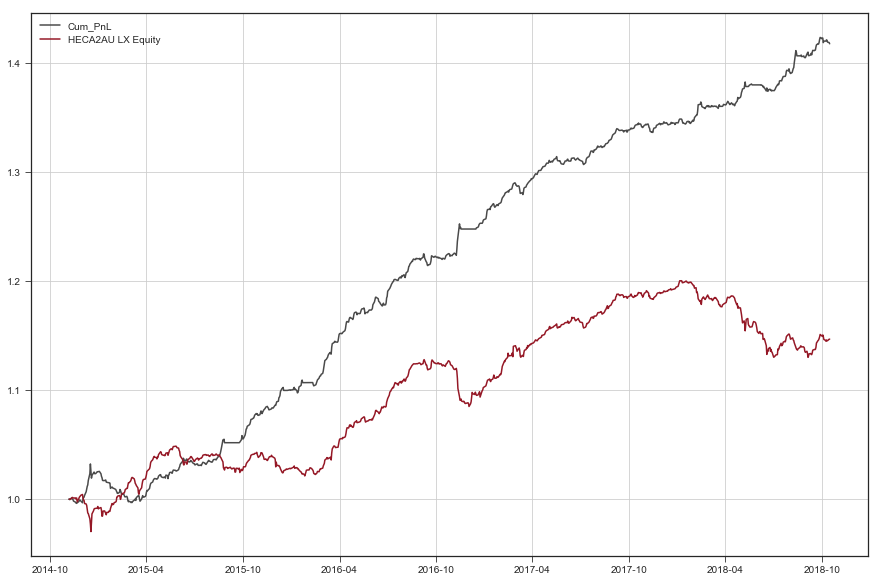

In [25]:
ed.graph(cemsig.pnl, hendo, chart_size=(15,10), legend=True, \
         #subgraph=rsi_l, \
         #trading_signal=trig, \
         view_grid=True,
         #save_fig="t.png",
        )

#### At sub index level (countries)

* Turkey

In [24]:
INDEX = "JBCDTU Index"
c_turk = bp.getHistoricalData(INDEX, "PX_LAST", "20141001", periodicity="DAILY")
var_name = c_turk
t_rsi_vs = ta.rsi(var_name, 5)
t_rsi_vs.columns = ['rsi_vs']
t_rsi_s = ta.rsi(var_name, 8)
t_rsi_s.columns = ['rsi_s']
t_rsi_l = ta.rsi(var_name, 18)
t_rsi_l.columns = ['rsi_l']
t_ma_vs = var_name.rolling(4).mean()
t_ma_vs.columns = ['ma_vs']
t_ma_s = var_name.rolling(10).mean()
t_ma_s.columns = ['ma_s']
t_ma_l = var_name.rolling(22).mean()
t_ma_l.columns = ['ma_l']

# Avoid NaN is MA
c_turk = var_name[start_d:]
t_rsi_vs = t_rsi_vs[start_d:]
t_rsi_s = t_rsi_s[start_d:]
t_rsi_l = t_rsi_l[start_d:]
t_ma_vs = t_ma_vs[start_d:]
t_ma_s = t_ma_s[start_d:]
t_ma_l = t_ma_l[start_d:]

C:\Users\herve.biancotto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  


In [25]:
turksig = sim.Signal(c_turk)
turksig.add_rule({'cover and buy': [
                                       [t_rsi_vs,'level','above', t_rsi_s, None],
                                       [t_rsi_s,'cross','above', t_rsi_l, 'AND'],
                                       [t_rsi_vs,'level','above', 30, 'AND'],
                                       [t_rsi_s,'level','above', 30, 'AND'],
                                       [t_rsi_l,'level','above', 30, 'AND'],
                                       [c_turk,'level','above', t_ma_vs, 'AND'],
                                    ],
                  'close and sell': [
                                        [t_rsi_vs,'level','below', t_rsi_s, None],
                                        [t_rsi_s, 'cross', 'below', t_rsi_l,'AND'],
                                        [t_rsi_vs,'level','below', 70, 'AND'],
                                        [t_rsi_s,'level','below', 70, 'AND'],
                                        [t_rsi_l,'level','below', 70, 'AND'],
                                        [c_turk,'level','below', t_ma_vs, 'AND'],
                                        [t_rsi_vs,'level','below', 30, 'OR'],
                                        [t_rsi_s,'level','below', 30, 'AND'],
                                        [t_rsi_l,'cross','below', 30, 'AND'],
                                      ],
                  'buy': [
                               [c_turk,'level','below', t_ma_vs, None],
                               [t_ma_s, 'level', 'above', t_ma_l,'AND']
                         ],
                  'exit short': [
                                    [c_turk,'cross','above', t_ma_vs, None],
                                    [t_ma_s, 'level', 'above', t_ma_vs,'AND'],
                                    [t_ma_l, 'level', 'above', t_ma_s,'AND'],
                                    [t_rsi_vs, 'level', 'below', 40,'AND'],
                                    [t_rsi_s, 'level', 'below', 40,'AND'],
                                    [t_rsi_l, 'level', 'below', 40,'AND']
                                ],
                 })

In [26]:
turksig.eval_strat()

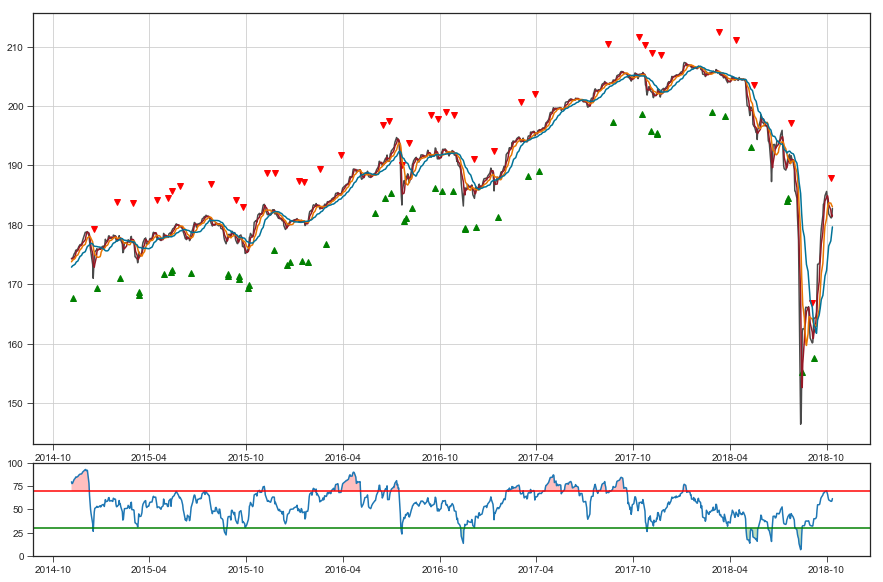

In [27]:
ed.graph(c_turk, t_ma_vs, t_ma_s, t_ma_l, chart_size=(15,10), legend=False, \
         subgraph=t_rsi_l, \
         trading_signal=turksig.trigger, \
         view_grid=True,
         #save_fig="t.png",
        )

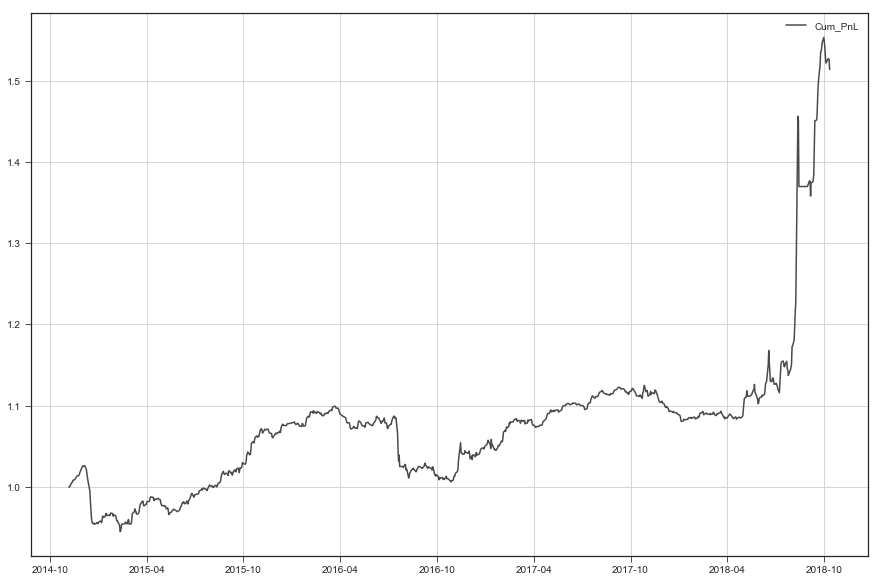

In [28]:
ed.graph(turksig.pnl, chart_size=(15,10), legend=True, \
         #subgraph=rsi_l, \
         #trading_signal=trig, \
         view_grid=True,
         #save_fig="t.png",
        )

* Brazil

In [29]:
INDEX = "JBCDBR Index"
c_bra = bp.getHistoricalData(INDEX, "PX_LAST", "20141001", periodicity="DAILY")
var_name = c_bra
b_rsi_vs = ta.rsi(var_name, 5)
b_rsi_vs.columns = ['rsi_vs']
b_rsi_s = ta.rsi(var_name, 8)
b_rsi_s.columns = ['rsi_s']
b_rsi_l = ta.rsi(var_name, 18)
b_rsi_l.columns = ['rsi_l']
b_ma_vs = var_name.rolling(4).mean()
b_ma_vs.columns = ['ma_vs']
b_ma_s = var_name.rolling(10).mean()
b_ma_s.columns = ['ma_s']
b_ma_l = var_name.rolling(22).mean()
b_ma_l.columns = ['ma_l']

# Avoid NaN is MA
c_bra = var_name[start_d:]
b_rsi_vs = b_rsi_vs[start_d:]
b_rsi_s = b_rsi_s[start_d:]
b_rsi_l = b_rsi_l[start_d:]
b_ma_vs = b_ma_vs[start_d:]
b_ma_s = b_ma_s[start_d:]
b_ma_l = b_ma_l[start_d:]

C:\Users\herve.biancotto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  


In [30]:
brasig = sim.Signal(c_bra)
brasig.add_rule({'cover and buy': [
                                       [b_rsi_vs,'level','above', b_rsi_s, None],
                                       [b_rsi_s,'cross','above', b_rsi_l, 'AND'],
                                       [b_rsi_vs,'level','above', 30, 'AND'],
                                       [b_rsi_s,'level','above', 30, 'AND'],
                                       [b_rsi_l,'level','above', 30, 'AND'],
                                       [c_bra,'level','above', b_ma_vs, 'AND'],
                                    ],
                  'close and sell': [
                                        [b_rsi_vs,'level','below', b_rsi_s, None],
                                        [b_rsi_s, 'cross', 'below', b_rsi_l,'AND'],
                                        [b_rsi_vs,'level','below', 70, 'AND'],
                                        [b_rsi_s,'level','below', 70, 'AND'],
                                        [b_rsi_l,'level','below', 70, 'AND'],
                                        [c_bra,'level','below', b_ma_vs, 'AND'],
                                        [b_rsi_vs,'level','below', 30, 'OR'],
                                        [b_rsi_s,'level','below', 30, 'AND'],
                                        [b_rsi_l,'cross','below', 30, 'AND'],
                                      ],
                'buy': [
                           [c_bra,'level','below', b_ma_vs, None],
                           [b_ma_s, 'level', 'above', b_ma_l,'AND']
                       ],
                'exit short': [
                                [c_bra,'cross','above', b_ma_vs, None],
                                [b_ma_s, 'level', 'above', b_ma_vs,'AND'],
                                [b_ma_l, 'level', 'above', b_ma_s,'AND'],
                                [b_rsi_vs, 'level', 'below', 40,'AND'],
                                [b_rsi_s, 'level', 'below', 40,'AND'],
                                [b_rsi_l, 'level', 'below', 40,'AND']
                              ],
                })

In [31]:
brasig.eval_strat()

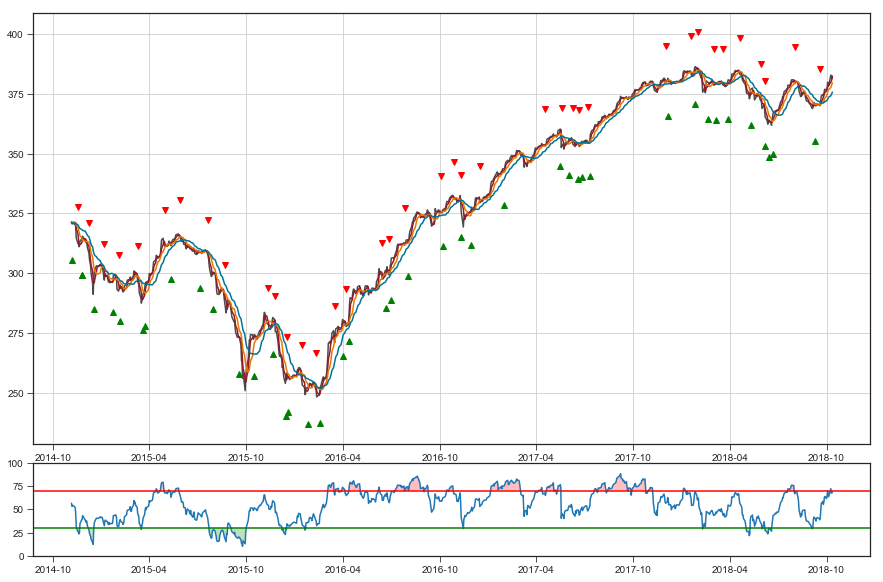

In [32]:
ed.graph(c_bra, b_ma_vs, b_ma_s, b_ma_l, chart_size=(15,10), legend=False, \
         subgraph=b_rsi_l, \
         trading_signal=brasig.trigger, \
         view_grid=True,
         #save_fig="t.png",
        )

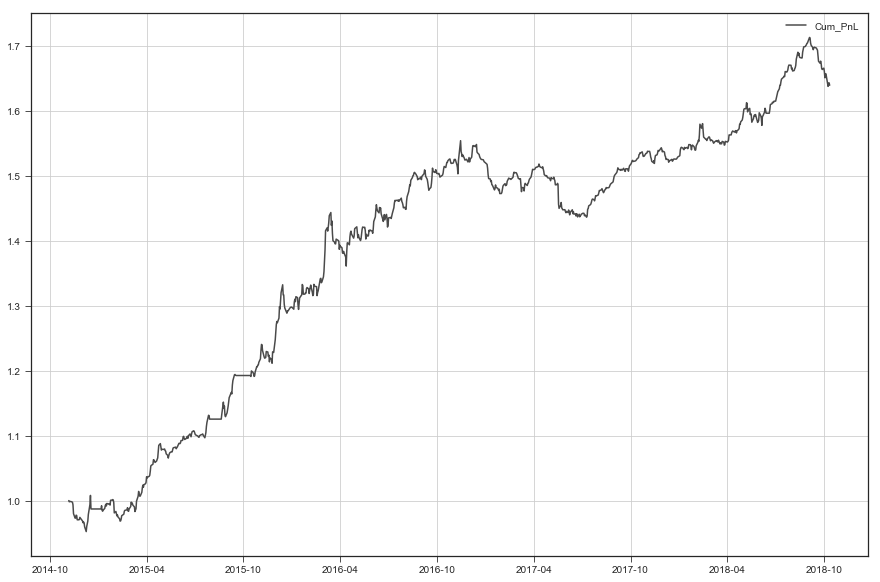

In [33]:
ed.graph(brasig.pnl, chart_size=(15,10), legend=True, \
         #subgraph=rsi_l, \
         #trading_signal=trig, \
         view_grid=True,
         #save_fig="t.png",
        )

## Naive optimisation of current strategy

In [87]:
# Define ranges for grid search

In [88]:
rsi_low = [20, 25, 30, 35]
rsi_high_2 = [40, 45, 50, 55, 60]
rsi_high = [50, 55, 60, 65, 70]
rsi_short_stop = [30, 35, 40, 45] 

vs_r = range(5,7) # i
s_r = range(10,13) # j
l_r = range(17,22) # k

vs_ma = range(3,6) # l
s_ma = range(6,9) # m
l_ma = range(16,19) # n

In [89]:
# Loop throughout possibilities and save model characteristics and results

In [90]:
INDEX = 'JBCDCOMP Index'
start_d = pd.to_datetime("2003-01-03")
end_d = pd.to_datetime("2007-12-29")
cembi = bp.getHistoricalData(INDEX, "PX_LAST", "20021001", periodicity="DAILY")

C:\Users\herve.biancotto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  after removing the cwd from sys.path.


In [96]:
def run_strat(series, **kwargs):
    
    if 'rsi_low' in kwargs:
        rsi_low = kwargs['rsi_low']
    else:
        rsi_low = 20

    if 'rsi_high' in kwargs:
        rsi_high = kwargs['rsi_high']
    else:
        rsi_high = 55
            
    if 'rsi_high_2' in kwargs:
        rsi_high_2 = kwargs['rsi_high_2']
    else:
        rsi_high_2 = 45
        
    if 'rsi_short_stop' in kwargs:
        rsi_stop = kwargs['rsi_short_stop']
    else:
        rsi_stop = 40
    
    ret_strat=False
    if 'ret_strat' in kwargs:
        ret_strat = kwargs['ret_strat']
    
    data, r_vs, r_s, r_l, m_vs, m_s, m_l = series
    sig = sim.Signal(data)
    sig.add_rule({'cover and buy': [
                                       [r_vs,'level','above', r_s, None],
                                       [r_s,'cross','above', r_l, 'AND'],
                                       [r_vs,'level','above', rsi_low, 'AND'],
                                       [r_s,'level','above', rsi_low, 'AND'],
                                       [r_l,'level','above', rsi_low, 'AND'],
                                       [data,'level','above', m_vs, 'AND'],
                                    ],
                 'close and sell': [
                                        [r_vs,'level','below', r_s, None],
                                        [r_s, 'cross', 'below', r_l,'AND'],
                                        [r_vs,'level','below', rsi_high, 'AND'],
                                        [r_s,'level','below', rsi_high, 'AND'],
                                        [r_l,'level','below', rsi_high, 'AND'],
                                        [data,'level','below', m_vs, 'AND'],
                                        [r_vs,'level','below', rsi_high_2, 'OR'],
                                        [r_s,'level','below', rsi_high_2, 'AND'],
                                        [r_l,'cross','below', rsi_high_2, 'AND'],
                                      ],
                 'buy': [
                           [data,'level','below', m_vs, None],
                           [m_s, 'level', 'above', m_l,'AND']
                       ],
                 'exit short': [
                                [data,'cross','above', m_vs, None],
                                [m_s, 'level', 'above', m_vs,'AND'],
                                [m_l, 'level', 'above', m_s,'AND'],
                                [r_vs, 'level', 'below', rsi_stop,'AND'],
                                [r_s, 'level', 'below', rsi_stop,'AND'],
                                [r_l, 'level', 'below', rsi_stop,'AND']
                              ],
                 })
    #compute pnl
    sig.eval_strat()
    if ret_strat:
        return sig.pnl, sig.strategy, sig.trigger
    else:
        return sig.pnl

In [20]:
%%time
res = []
for i in vs_r:
    for j in s_r:
        for k in l_r:
            for l in vs_ma:
                for m in s_ma:
                    for n in l_ma:
                        data = cembi
                        r_vs = ta.rsi(data, i)
                        r_s = ta.rsi(data, j)
                        r_l = ta.rsi(data, k)
                        m_vs = data.rolling(l).mean()
                        m_s = data.rolling(m).mean()
                        m_l = data.rolling(n).mean()
                        # Avoid NaN is MA
                        data = data[start_d:end_d]
                        r_vs = r_vs[start_d:end_d]
                        r_s = r_s[start_d:end_d]
                        r_l = r_l[start_d:end_d]
                        m_vs = m_vs[start_d:end_d]
                        m_s = m_s[start_d:end_d]
                        m_l = m_l[start_d:end_d]


                        single_res = run_strat([
                                                data,
                                                r_vs,
                                                r_s,
                                                r_l,
                                                m_vs,
                                                m_s,
                                                m_l
                                                ])
                        res.append([single_res[-1],i,j,k,l,m,n])

NameError: name 'create_strategy' is not defined

In [21]:
npr = np.array(res)
plt.plot(npr[:,0])

IndexError: too many indices for array

In [ ]:
np.max(npr[:,0])

In [ ]:
np.argmax(npr[:,0],axis=0)

In [ ]:
npr[585,:]

* Tune the RSI bands

In [ ]:
%%time

data = cembi
r_vs = rsi(data, 6)
r_s = rsi(data, 11)
r_l = rsi(data, 18)
m_vs = data.rolling(5).mean()
m_s = data.rolling(8).mean()
m_l = data.rolling(18).mean()
# Avoid NaN is MA
data = data[start_d:end_d]
r_vs = r_vs[start_d:end_d]
r_s = r_s[start_d:end_d]
r_l = r_l[start_d:end_d]
m_vs = m_vs[start_d:end_d]
m_s = m_s[start_d:end_d]
m_l = m_l[start_d:end_d]

res_rsi = []
for r_low in rsi_low:
    for r_high_2 in rsi_high_2:
        for r_high in rsi_high:
            for r_s_stop in rsi_short_stop:
                single_res_rsi = run_strat([
                                        data,
                                        r_vs,
                                        r_s,
                                        r_l,
                                        m_vs,
                                        m_s,
                                        m_l
                                        ], rsi_low=r_low, rsi_high=r_high, rsi_high_2=r_high_2, rsi_short_stop=r_s_stop)
                res_rsi.append([single_res_rsi[-1], r_low, r_high, r_high_2, r_s_stop])

In [ ]:
np_rsi = np.array(res_rsi)
plt.plot(np_rsi[:,0])

In [ ]:
np.argmax(np_rsi[:,0],axis=0)

In [ ]:
np_rsi[26,:]

#### Results

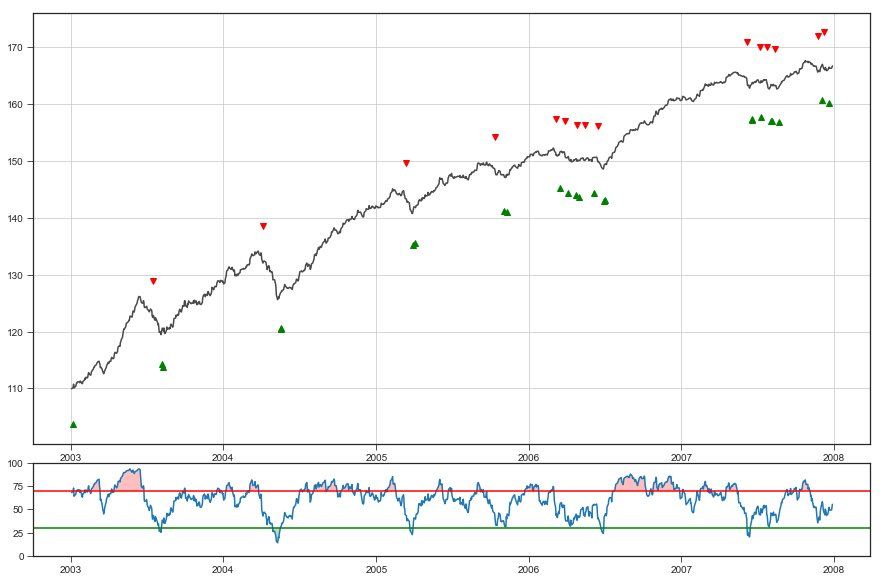

In [97]:
data = cembi
r_vs = ta.rsi(data, 6)
r_s = ta.rsi(data, 11)
r_l = ta.rsi(data, 18)
m_vs = data.rolling(5).mean()
m_s = data.rolling(8).mean()
m_l = data.rolling(18).mean()
# Avoid NaN is MA
data = data[start_d:end_d]
r_vs = r_vs[start_d:end_d]
r_s = r_s[start_d:end_d]
r_l = r_l[start_d:end_d]
m_vs = m_vs[start_d:end_d]
m_s = m_s[start_d:end_d]
m_l = m_l[start_d:end_d]

p, s, t = run_strat([data,r_vs,r_s,r_l,m_vs,m_s,m_l], rsi_low=20, rsi_high=55, rsi_high_2=45, rsi_short_stop=40, ret_strat=True)
ed.graph(data, chart_size=(15,10), legend=False, \
         subgraph=r_l, \
         trading_signal=t, \
         view_grid=True,
         #save_fig="t.png",
        )

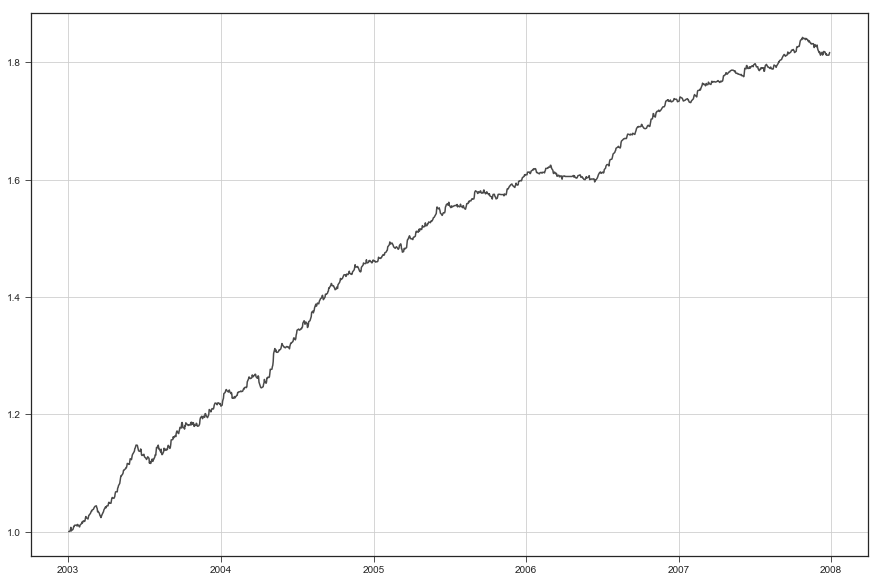

In [98]:
ed.graph(p, chart_size=(15,10), legend=False, view_grid=True)

## Advanced optimisation: reinforcement learning

### Dataset

Let organise data between a test set and a training set. Let also hold out parts of the training set for validation purposes. As the data is ordered through time, the construction of training, validation and test sets is crucial for generalisation.

In [99]:
cembi = bp.getHistoricalData("JBCDCOMP Index", "PX_LAST", "20141001", periodicity="DAILY")
rsi_c = ta.rsi(cembi, 14)
rsi_c.columns = ['rsi_c']

C:\Users\herve.biancotto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  """Entry point for launching an IPython kernel.


In [28]:
def train_test_split(df, test=0.2, shuffle=False, seed=None):
    n_row = df.shape[0]
    if not shuffle:
        test_df = df[int((1-test)*n_row):]
        train_df = df[:int((1-test)*n_row)]
    else:
        idx = np.arange(n_row)
        np.random.seed(seed)
        np.random.shuffle(idx)
        split = int(n_row*(1-test))
        test = idx[split:]
        train = idx[:split]
        test_df = df.iloc[test,:]
        train_df = df.iloc[train,:]
    return train_df, test_df

In [29]:
c_train, c_test = train_test_split(cembi)

In [30]:
c_test.head(), c_train.tail()

(            JBCDCOMP Index
 Date                      
 2017-11-20         313.732
 2017-11-21         313.819
 2017-11-22         314.250
 2017-11-24         314.340
 2017-11-27         314.609,             JBCDCOMP Index
 Date                      
 2017-11-13         312.759
 2017-11-14         312.916
 2017-11-15         312.716
 2017-11-16         313.261
 2017-11-17         313.631)

In [31]:
def train_valid_split(df_train, valid=0.2, shuffle=False, seed=None, multiple_sets=None):
    n_row = df_train.shape[0]
    if not shuffle:
        if multiple_sets is None:
            valid_df = df_train[int((1-valid)*n_row):]
            train_df = df_train[:int((1-valid)*n_row)]
        else:
            length = int(n_row / multiple_sets)
            split = int(length*(1-valid))
            t = []
            v = []
            for s in range(multiple_sets):
                t.append(df_train[s*length:s*length+split])
                v.append(df_train[s*length+split:min((s+1)*length,n_row)])
            train_df = pd.concat(t)
            valid_df = pd.concat(v)
    else:
        idx = np.arange(n_row)
        np.random.shuffle(idx)
        split = int(n_row*(1-valid))
        val = idx[split:]
        train = idx[:split]
        valid_df = df_train.iloc[val,:]
        train_df = df_train.iloc[train,:]
    return train_df, valid_df

In [32]:
c_tr, c_val = train_valid_split(c_train, valid=0.25, shuffle=False, multiple_sets=None)

In [33]:
c_train.shape, c_tr.shape, c_val.shape

((784, 1), (588, 1), (196, 1))

In [34]:
c_val.tail()

,JBCDCOMP Index
Date,
2017-11-13,312.759
2017-11-14,312.916
2017-11-15,312.716
2017-11-16,313.261
2017-11-17,313.631


### Policy

In [36]:
s = sim.Signal(cembi)

In [37]:
s.delete_rule({'cover and buy':'all',
               'close and sell':'all'})

In [41]:
s.add_rule({'cover and buy': [[rsi_c,'cross','above', 30, None], [rsi_c,'cross','above', 70, 'OR']],
            'close and sell': [[rsi_c,'cross','below', 70, None], [rsi_c,'cross','below', 30, 'OR']]})

In [39]:
s.delete_rule({'cover and buy': 'all',
               'close and sell': 'all'})

In [40]:
s

In [42]:
s.eval_strat()

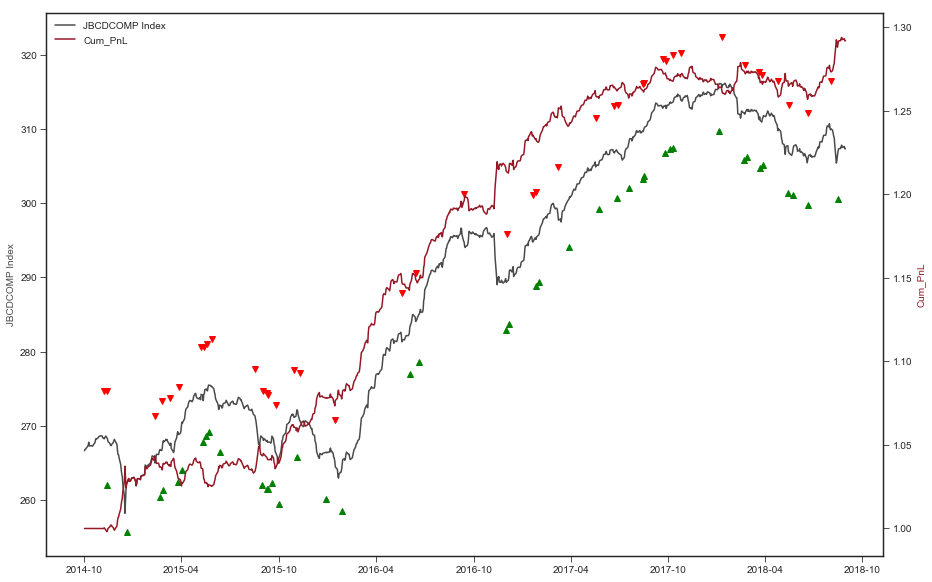

In [43]:
ed.graph(cembi, s.pnl, multiple_series=True,
        trading_signal=s.trigger,
         chart_size=(15,10))

In [44]:
ACTIONS = ['buy',
           'sell',
           'cover and buy',
           'close and sell',
           'exit long',
           'exit short'
          ]

In [83]:
RANGES = {'rsi':[3,100],
          'ma':[2,200]}

INCREMENT = {'rsi':lambda x: 1 if x<=14 else 5,
             'ma':lambda x: 1 if x<=12 else 5}

In [74]:
def update_matrix():
    pass

In [ ]:
matrix = a


In [84]:
INCREMENT['rsi'](16)

5

In [101]:
import torch